In [55]:
import kaggle
import os, zipfile

kaggle.api.authenticate()

comp = "house-prices-advanced-regression-techniques"
path = "data_ames"
os.makedirs(path, exist_ok=True)

kaggle.api.competition_download_files(comp, path=path)

with zipfile.ZipFile(os.path.join(path, f"{comp}.zip"), "r") as z:
    z.extractall(path)

os.listdir(path)

['test.csv',
 'data_description.txt',
 'house-prices-advanced-regression-techniques.zip',
 'train.csv',
 'sample_submission.csv']

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("data_ames/train.csv")
test = pd.read_csv("data_ames/test.csv")

train.shape, test.shape

train.head()
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [57]:
FAST_MODE = False

y = train["SalePrice"]
X = train.drop(columns=["SalePrice"])

y_log = np.log(y)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

X_fe = X.copy()

# Total square footage
X_fe["TotalSF"] = (
    X_fe["TotalBsmtSF"].fillna(0)
    + X_fe["1stFlrSF"]
    + X_fe["2ndFlrSF"]
)

# House age at sale
X_fe["HouseAge"] = X_fe["YrSold"] - X_fe["YearBuilt"]

# Years since remodel
X_fe["RemodAge"] = X_fe["YrSold"] - X_fe["YearRemodAdd"]

# Total bathrooms (full + half)
X_fe["TotalBath"] = (
    X_fe["FullBath"]
    + 0.5 * X_fe["HalfBath"]
    + X_fe["BsmtFullBath"].fillna(0)
    + 0.5 * X_fe["BsmtHalfBath"].fillna(0)
)

X_fe2 = X_fe.copy()
X_fe2["AreaPerRoom"] = X_fe2["GrLivArea"] / X_fe2["TotRmsAbvGrd"]
X_fe2["LogGrLivArea"] = np.log1p(X_fe2["GrLivArea"])

X = X_fe2

if FAST_MODE:
    X_tune = X_fe2.sample(n=300, random_state=42)
    y_tune = y_log.loc[X_tune.index]
else:
    X_tune = X_fe2
    y_tune = y_log

X_train, X_valid, y_train, y_valid = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)



In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
numeric_cols     = [c for c in X_train.columns if X_train[c].dtype != "object"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [59]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline

model = HistGradientBoostingRegressor(random_state=42)

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

param_space = {
    "model__learning_rate": [0.02, 0.04, 0.06, 0.08, 0.1],
    "model__max_iter": [300, 500, 700, 900, 1200],
    "model__max_depth": [5, 7, 9, None],
    "model__min_samples_leaf": [20, 50, 100],
    "model__l2_regularization": [0.0, 0.1, 0.5],
}

In [60]:
from sklearn.metrics import mean_absolute_error

pipe.fit(X_train, y_train)

pred_log = pipe.predict(X_valid)

pred = np.exp(pred_log)
actual = np.exp(y_valid)

mae_fe = mean_absolute_error(actual, pred)
mae_fe

15890.026969778617

In [61]:
from sklearn.model_selection import RandomizedSearchCV

n_iter = 8 if FAST_MODE else 25
cv = 3 if FAST_MODE else 5

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_space,
    n_iter=n_iter,
    scoring="neg_mean_absolute_error",
    cv=cv,
    random_state=42,
    n_jobs=8,
    verbose=1
)

search.fit(X_train, y_train)

best_cv_mae_log = -search.best_score_
search.best_params_, best_cv_mae_log

best_model = search.best_estimator_

pred_log = best_model.predict(X_valid)
pred = np.exp(pred_log)
actual = np.exp(y_valid)

from sklearn.metrics import mean_absolute_error
mae_tuned = mean_absolute_error(actual, pred)
mae_tuned

Fitting 5 folds for each of 25 candidates, totalling 125 fits


16621.00204967294

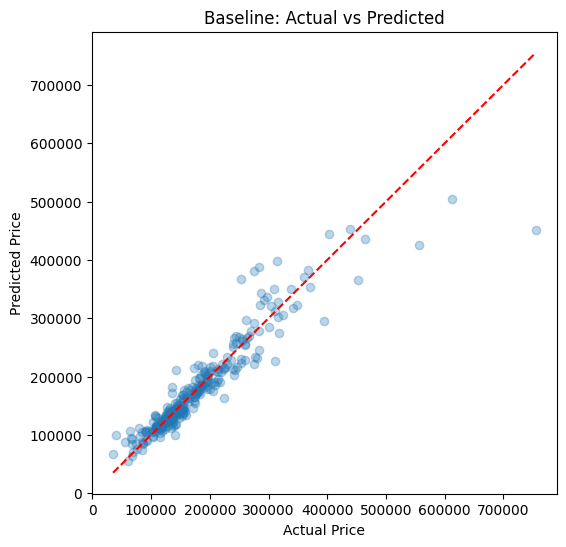

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(actual, pred, alpha=0.3)
plt.plot([actual.min(), actual.max()],
         [actual.min(), actual.max()], "r--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Baseline: Actual vs Predicted")
plt.show()

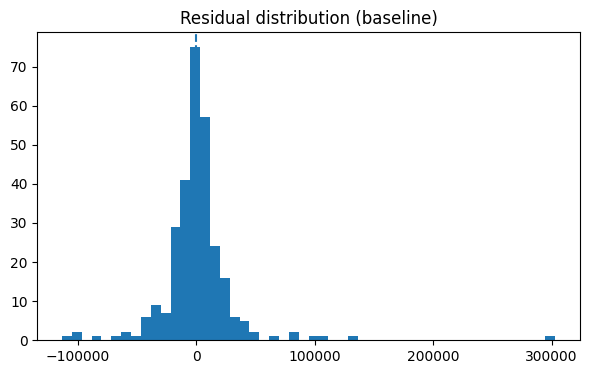

In [63]:
resid = actual - pred

plt.figure(figsize=(7,4))
plt.hist(resid, bins=50)
plt.axvline(0, linestyle="--")
plt.title("Residual distribution (baseline)")
plt.show()

In [64]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    pipe, X_valid, y_valid,
    n_repeats=10,
    random_state=42,
    n_jobs=8
)

imp = pd.Series(perm.importances_mean, index=X_valid.columns).sort_values(ascending=False)
imp.head(15)

TotalSF          0.258593
OverallQual      0.178218
GrLivArea        0.014793
OverallCond      0.014343
GarageCars       0.014091
TotalBath        0.010723
LotArea          0.010556
CentralAir       0.009910
Neighborhood     0.005096
RemodAge         0.004894
YearBuilt        0.004686
GarageArea       0.004276
BsmtFinSF1       0.003717
SaleCondition    0.003233
1stFlrSF         0.003195
dtype: float64